In [1]:
"""
This script is used to analyze data and produce Figures 4BCDEF of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
rootDir = "/content/drive/MyDrive/SYNC_Projects/"

rootDir = rootDir + "pBGT/GIT/"

data_path = rootDir + "data/uJ_data/"
fig_path = rootDir + "figures/"

frame2min=10
dark_orange='#FF985A'
light_orange='#FFDC97'
dark_blue='#779ECC'
light_blue='#9FC0DE'

t_antibiotic_start=60

## Load and analyze data

The following code loads and processes a summary file of cells processed by analyzing time-lapse movies. The cells are categorized based on whether they are filamented or not and whether they survived or not. The processed data is stored in a pandas dataframe called __cells_df__.

In [5]:

# set the data directory
data_dir = os.path.join(data_path)

# read in the cells summary file and remove the over_ds_red_id column, then rename divided_id to divided
cells_file = os.path.join(data_path, "cells_summary.csv")
cells_raw_df = pd.read_csv(cells_file).drop("over_ds_red_id", axis=1).rename(columns={"divided_id": "divided"})

# assign categorical data types to filamented_id, survived, and cell_status columns
cells_df = cells_raw_df.assign(
    filamented_id=pd.Categorical(
        cells_raw_df['filamented_id'].replace({False: 'Not filamented', True: 'Filamented'}),
        categories=[False, True],
        ordered=True
    ),
    survived=pd.Categorical(
        cells_raw_df['survived'].replace({False: 'Not survived', True: 'Survived'}),
        categories=[False, True],
        ordered=True
    ),
    cell_status=cells_raw_df['filamented_id'].replace(
        {False: 'Not filamented', True: 'Filamented'}
    ) + ' - ' + cells_raw_df['survived'].replace(
        {False: 'Not survived', True: 'Survived'}
    )
)

# set the cell_status column as a categorical data type
cells_df['cell_status'] = pd.Categorical(cells_df['cell_status'])

# split the dataframe into object and non-object columns, and rejoin them in the original order
cells_df = cells_df.loc[:, cells_df.dtypes == object].join(
    cells_df.loc[:, cells_df.dtypes != object]
)


display(cells_df.head(2))
display(cells_df.tail(2))
display(cells_df.info())

,experiment_id,id,divided_once_experiment_finished,filamented_id,divided,survived,antibiotic_start_time,antibiotic_end_time,filamentation_threshold,time_first,...,gfp_sos,gfp_last,ds_red_first,ds_red_sos,ds_red_last,n_divisions,time_since_last_division_to_experiment_start,lived_time,dead_or_missing_at_time,cell_status
0,Chromosome,xy01_1_10.008-34.000,True,NaN,True,NaN,60,100,38.22991,0,...,0.985546,0.978385,0.006165,0.006423,0.000206,2,0.0,110,NaN,Filamented - Survived
1,Chromosome,xy01_1_11.006-26.003,False,NaN,True,NaN,60,100,38.22991,10,...,0.985546,0.983784,0.006423,0.006423,-0.000481,1,50.0,100,NaN,Filamented - Survived


,experiment_id,id,divided_once_experiment_finished,filamented_id,divided,survived,antibiotic_start_time,antibiotic_end_time,filamentation_threshold,time_first,...,gfp_sos,gfp_last,ds_red_first,ds_red_sos,ds_red_last,n_divisions,time_since_last_division_to_experiment_start,lived_time,dead_or_missing_at_time,cell_status
6885,Plasmid,xy47_9_20.018-44.012,True,NaN,True,NaN,60,140,47.167569,0,...,0.813726,0.814651,0.001719,0.183321,0.004576,3,0.0,150,NaN,Filamented - Survived
6886,Plasmid,xy47_9_25.016-28.018,False,NaN,True,NaN,60,140,47.167569,50,...,NaN,0.854704,0.002828,NaN,0.166546,1,10.0,30,90.0,Not filamented - Not survived


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6887 entries, 0 to 6886
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   experiment_id                                 6887 non-null   object  
 1   id                                            6887 non-null   object  
 2   divided_once_experiment_finished              6887 non-null   bool    
 3   filamented_id                                 0 non-null      category
 4   divided                                       6887 non-null   bool    
 5   survived                                      0 non-null      category
 6   antibiotic_start_time                         6887 non-null   int64   
 7   antibiotic_end_time                           6887 non-null   int64   
 8   filamentation_threshold                       6887 non-null   float64 
 9   time_first                                    6887 n

None

The following code reads a CSV file called "processed_lineages.csv" using pandas and stores it in a DataFrame called "lineages_raw_df". It then processes the DataFrame by converting certain columns to categorical data types, renaming categories, and combining columns to create a new categorical column. The resulting processed DataFrame is stored in "lineages_processed_df".

The code then creates a new DataFrame called "status_time_df" by selecting certain columns from "lineages_processed_df", grouping by "experiment_id" and "id", and merging with "lineages_processed_df". The column "cell_status_at_time" is converted to a categorical data type with specific categories and ordered accordingly.

In [6]:
# Define the file path to the processed lineages data
lineages_file = data_path + "processed_lineages.csv"

# Load the processed lineages data into a pandas dataframe
lineages_raw_df = pd.read_csv(lineages_file)

# Assign categorical variables to the "filamented_id", "filamented_at_time", and "survived" columns
lineages_processed_df = lineages_raw_df.assign(
    filamented_id = pd.Categorical(
        lineages_raw_df.filamented_id,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not filamented", "Filamented"]),
    filamented_at_time = pd.Categorical(
        lineages_raw_df.filamented_at_time,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not filamented", "Filamented"]),
    survived = pd.Categorical(
        lineages_raw_df.survived,
        categories=[False, True],
        ordered=False
    ).rename_categories(["Not survived", "Survived"]),

    # Combine "filamented_id" and "survived" columns into a new "cell_status" column
    cell_status = (
        lineages_raw_df["filamented_id"].map({
            False: "Not filamented",
            True: "Filamented"
        }) + " - " +
        lineages_raw_df["survived"].map({
            False: "Not survived",
            True: "Survived"
        })
    ).astype("category")
)

#display(lineages_processed_df.head(2))

# Group by "experiment_id", "id", and "time", and apply the grouping to the dataframe
status_time_df_a = (lineages_processed_df
                  .loc[:, ['experiment_id', 'id', 'time']]
                  .groupby(['experiment_id', 'id'], group_keys=False)
                  .apply(lambda x: x)
                    )

# Merge the processed lineages dataframe with the grouped dataframe on "experiment_id", "id", and "time"
status_time_df=(status_time_df_a.merge(lineages_processed_df, on=['experiment_id', 'id', 'time'], how='left')
                  .rename(columns={'filamented_at_time': 'cell_status_at_time'})

                  # Forward fill and backward fill any missing data
                  .fillna(method='ffill')
                  .fillna(method='bfill')

                  # Assign categorical variables to the "cell_status_at_time" column
                  .assign(cell_status_at_time=lambda x: x['cell_status_at_time'].astype(str)
                          .fillna('Dead')
                          .astype('category')
                          .cat.set_categories(['Not filamented', 'Filamented', 'Dead'], ordered=True),
                          )
                   )

# Display the first two rows of the final status_time dataframe
display(status_time_df.head(2))
display(status_time_df.info())
status_time_df.describe()

,experiment_id,id,time,division,cell_status_at_time,over_ds_red_threshold_at_time,filamented_id,survived,length,gfp,...,antibiotic_end_time,length_mean,gfp_mean,ds_red_mean,filamentation_threshold,ds_red_threshold,time_first,time_last,gfp_first,cell_status
0,Chromosome,xy01_1_10.008-34.000,0,False,Not filamented,False,Filamented,Survived,25.849646,0.984079,...,100,26.032382,122.053191,107.727847,38.22991,146.11125,0,110,0.984079,Filamented - Survived
1,Chromosome,xy01_1_10.008-34.000,10,True,Filamented,False,Filamented,Survived,41.415166,0.985546,...,100,26.032382,122.053191,107.727847,38.22991,146.11125,0,110,0.984079,Filamented - Survived


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98768 entries, 0 to 98767
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   experiment_id                  98768 non-null  object  
 1   id                             98768 non-null  object  
 2   time                           98768 non-null  int64   
 3   division                       98768 non-null  bool    
 4   cell_status_at_time            98768 non-null  category
 5   over_ds_red_threshold_at_time  98768 non-null  bool    
 6   filamented_id                  98768 non-null  category
 7   survived                       98768 non-null  category
 8   length                         98768 non-null  float64 
 9   gfp                            98768 non-null  float64 
 10  ds_red                         98768 non-null  float64 
 11  antibiotic_start_time          98768 non-null  int64   
 12  antibiotic_end_time            9

None

,time,length,gfp,ds_red,antibiotic_start_time,antibiotic_end_time,length_mean,gfp_mean,ds_red_mean,filamentation_threshold,ds_red_threshold,time_first,time_last,gfp_first
count,98768.000000,98768.000000,98768.000000,98768.000000,98768.0,98768.000000,98768.000000,98768.000000,98768.000000,98768.000000,98768.000000,98768.000000,98768.000000,98768.000000
mean,91.013689,31.353097,0.993718,0.073224,60.0,134.849749,27.830664,248.204665,99.287640,46.016789,139.400495,4.725012,127.548092,1.022685
std,66.725936,15.754549,0.221535,0.106736,0.0,13.397267,0.691313,48.496333,3.244663,2.993505,2.579811,12.297972,29.025907,0.206798
min,0.000000,5.253672,0.498078,-0.015905,60.0,100.000000,26.032382,122.053191,98.040309,38.229910,138.408750,0.000000,60.000000,0.585408
25%,40.000000,22.317995,0.855055,-0.000019,60.0,140.000000,28.096422,266.847891,98.040309,47.167569,138.408750,0.000000,110.000000,0.897159
50%,70.000000,27.951655,0.977420,0.008791,60.0,140.000000,28.096422,266.847891,98.040309,47.167569,138.408750,0.000000,150.000000,0.994870
75%,140.000000,35.976621,1.075763,0.143486,60.0,140.000000,28.096422,266.847891,98.040309,47.167569,138.408750,0.000000,150.000000,1.106612
max,240.000000,428.428360,3.793120,0.615701,60.0,140.000000,28.096422,266.847891,107.727847,47.167569,146.111250,50.000000,150.000000,2.731537


## Measuring time between divisions

### Overall

In [7]:
experiment_id="Chromosome"
exp_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    ]

tnext_C=[]
for id in exp_df.id.unique():
    id_df=exp_df[exp_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_C=tnext_C+dx2
chromosome_time_divs=np.mean(tnext_C)


experiment_id="Plasmid"
exp_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    ]

tnext_P=[]
for id in exp_df.id.unique():
    id_df=exp_df[exp_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_P=tnext_P+dx2
plasmid_time_divs=np.mean(tnext_P)


print('Time between divisions: Plasmid vs Chromosome')
print("Plasmid: ",plasmid_time_divs*10)
print("Chromosome: ",chromosome_time_divs*10)
t_statistic, p_value = ttest_ind(tnext_P,tnext_C)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions: Plasmid vs Chromosome
Plasmid:  46.53048780487805
Chromosome:  29.794238683127574
	T-statistic: 16.066179530013457
	P-value: 9.898514252337242e-57
		Statistically significant!


### Before antibiotics

In [8]:
experiment_id="Chromosome"
exp_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                            & (lineages_raw_df["time"] < t_antibiotic_start)
                                    ]

tnext_C=[]
for id in exp_df.id.unique():
    id_df=exp_df[exp_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_C=tnext_C+dx2
chromosome_time_divs=np.mean(tnext_C)


experiment_id="Plasmid"
exp_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                            & (lineages_raw_df["time"] < t_antibiotic_start)
                                    ]

tnext_P=[]
for id in exp_df.id.unique():
    id_df=exp_df[exp_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_P=tnext_P+dx2
plasmid_time_divs=np.mean(tnext_P)


print('Time between divisions: Plasmid vs Chromosome')
print("Plasmid: ",plasmid_time_divs*10)
print("Chromosome: ",chromosome_time_divs*10)
t_statistic, p_value = ttest_ind(tnext_P,tnext_C)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions: Plasmid vs Chromosome
Plasmid:  21.26917712691771
Chromosome:  18.702163061564058
	T-statistic: 4.1162793995727265
	P-value: 4.089874178057913e-05
		Statistically significant!


### Survived vs Not survived

#### Chromosome

In [9]:
experiment_id="Chromosome"
exp_S_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    & (lineages_raw_df["survived"] == True) ]
exp_NS_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    & (lineages_raw_df["survived"] == False) ]


lin_divs=[]
tnext_CS=[]
for id in exp_S_df.id.unique():
    id_df=exp_S_df[exp_S_df["id"]==id]
    divs=id_df.division
    n_lin=len(divs)
    n_divs=sum(divs)
    rate=n_divs/n_lin
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_CS=tnext_CS+dx2
    lin_divs.append(rate)
tnext_CNS=[]
for id in exp_NS_df.id.unique():
    id_df=exp_NS_df[exp_NS_df["id"]==id]
    divs=id_df.division
    n_lin=len(divs)
    n_divs=sum(divs)
    rate=n_divs/n_lin
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_CNS=tnext_CNS+dx2
    lin_divs.append(rate)


chromosome_rate=np.mean(lin_divs)
chromosome_time_divs_S=np.mean(tnext_CS)
chromosome_time_divs_NS=np.mean(tnext_CNS)


print('Time between divisions Chromosome: Survived vs Not survived')
print("Survived: ",chromosome_time_divs_S*10)
print("Not survived: ",chromosome_time_divs_NS*10)
t_statistic, p_value = ttest_ind(tnext_CS,tnext_CNS)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions Chromosome: Survived vs Not survived
Survived:  31.831076724693744
Not survived:  21.755725190839694
	T-statistic: 6.698767526471175
	P-value: 2.7440225688661996e-11
		Statistically significant!


#### Plasmid

In [10]:
experiment_id="Plasmid"
exp_S_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    & (lineages_raw_df["survived"] == True) ]
exp_NS_df = lineages_raw_df.loc[(lineages_raw_df["experiment_id"] == experiment_id)
                                    & (lineages_raw_df["survived"] == False) ]


lin_divs=[]
tnext_PS=[]
for id in exp_S_df.id.unique():
    id_df=exp_S_df[exp_S_df["id"]==id]
    divs=id_df.division
    n_lin=len(divs)
    n_divs=sum(divs)
    rate=n_divs/n_lin
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_PS=tnext_PS+dx2
    lin_divs.append(rate)
tnext_PNS=[]
for id in exp_NS_df.id.unique():
    id_df=exp_NS_df[exp_NS_df["id"]==id]
    divs=id_df.division
    n_lin=len(divs)
    n_divs=sum(divs)
    rate=n_divs/n_lin
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_PNS=tnext_PNS+dx2
    lin_divs.append(rate)


plasmid_rate=np.mean(lin_divs)
plasmid_time_divs_S=np.mean(tnext_PS)
plasmid_time_divs_NS=np.mean(tnext_PNS)


print('Time between divisions Plasmid: Survived vs Not survived')
print("Survived: ",plasmid_time_divs_S*10)
print("Not survived: ",plasmid_time_divs_NS*10)
t_statistic, p_value = ttest_ind(tnext_PS,tnext_PNS)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions Plasmid: Survived vs Not survived
Survived:  51.27413127413128
Not survived:  28.72463768115942
	T-statistic: 13.177001407489412
	P-value: 1.125863908615545e-38
		Statistically significant!


#### Both before antibiotics

In [11]:
exp_S_df = lineages_raw_df.loc[(lineages_raw_df["survived"] == True)
                                & (lineages_raw_df["time"] < t_antibiotic_start)]
exp_NS_df = lineages_raw_df.loc[(lineages_raw_df["survived"] == False)
                                & (lineages_raw_df["time"] < t_antibiotic_start) ]


lin_divs=[]
tnext_S=[]
for id in exp_S_df.id.unique():
    id_df=exp_S_df[exp_S_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_S=tnext_S+dx2

tnext_NS=[]
for id in exp_NS_df.id.unique():
    id_df=exp_NS_df[exp_NS_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_NS=tnext_NS+dx2

time_divs_S=np.mean(tnext_S)
time_divs_NS=np.mean(tnext_NS)


print('Time between divisions both: Survived vs Not survived')
print("Survived: ",time_divs_S*10)
print("Not survived: ",time_divs_NS*10)
t_statistic, p_value = ttest_ind(tnext_S,tnext_NS)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions both: Survived vs Not survived
Survived:  20.26243093922652
Not survived:  19.8989898989899
	T-statistic: 0.5785668082817811
	P-value: 0.562980505404593


#### Both whole experiment

In [12]:
exp_S_df = lineages_raw_df.loc[(lineages_raw_df["survived"] == True)
                               ]
exp_NS_df = lineages_raw_df.loc[(lineages_raw_df["survived"] == False)
                               ]


lin_divs=[]
tnext_S=[]
for id in exp_S_df.id.unique():
    id_df=exp_S_df[exp_S_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_S=tnext_S+dx2

tnext_NS=[]
for id in exp_NS_df.id.unique():
    id_df=exp_NS_df[exp_NS_df["id"]==id]
    divs=id_df.division
    dx=np.where(divs==True)[0]
    dx2=[dx[i]-dx[i-1] for i in range(1,len(dx))]
    tnext_NS=tnext_NS+dx2

time_divs_S=np.mean(tnext_S)
time_divs_NS=np.mean(tnext_NS)


print('Time between divisions both: Survived vs Not survived')
print("Survived: ",time_divs_S*10)
print("Not survived: ",time_divs_NS*10)
t_statistic, p_value = ttest_ind(tnext_S,tnext_NS)
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")


Time between divisions both: Survived vs Not survived
Survived:  43.991789422844725
Not survived:  26.195752539242847
	T-statistic: 14.2551810772574
	P-value: 2.914244933929876e-45
		Statistically significant!


This function creates a bar plot showing the survival status and filamentation of cells in two experiments ('Chromosome' and 'Plasmid').

For each experiment, the function calculates the number of cells that survived or did not survive, and the number of cells that were filamented or not filamented. It then plots two bars, one for the cells that did not survive and one for the cells that survived, and divides each bar into two sub-bars representing the cells that were filamented and not filamented.

The height of each sub-bar represents the percentage of cells that fall into that category, with the total height of each bar representing 100% of the cells. The color of each sub-bar is determined by the filamentation and survival status.

## Figure 4B


Not filamented/Not survived: 368 cells (34.2%)
Filamented/Not survived: 206 cells (19.1%) 
Total not survived (Chromosome) -> 574 cell lineages 
 
Not filamented/Survived: 368 cells (34.2%)
Filamented/Survived: 206 cells (19.1%) 
Total survived (Chromosome) -> 503 cell lineages 
 

Not filamented/Not survived: 2814 cells (48.4%)
Filamented/Not survived: 424 cells (7.3%) 
Total not survived (Plasmid) -> 3238 cell lineages 
 
Not filamented/Survived: 2814 cells (48.4%)
Filamented/Survived: 424 cells (7.3%) 
Total survived (Plasmid) -> 2572 cell lineages 
 


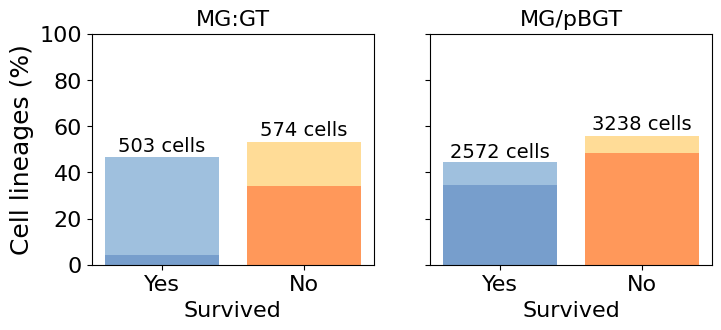

In [17]:

def plot_cells_status(cells_raw_df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)
    fig.set_facecolor('white')

    for i, experiment_id in enumerate(["Chromosome", "Plasmid"]):

        if experiment_id=='Chromosome':
          experiment_lbl='MG:GT'
        else:
          experiment_lbl='MG/pBGT'

        exp_df = cells_raw_df[cells_raw_df["experiment_id"] == experiment_id]
        survived_grouped = exp_df.groupby("survived")
        survived_counts = survived_grouped["id"].nunique()
        total_ids = survived_counts.sum()

        filamented_grouped = exp_df.groupby(["survived", "filamented_id"])
        filamented_counts = filamented_grouped["id"].nunique()

        ax = axes[i]
        ax.set_title(experiment_lbl, fontsize=16)
        ax.set_xticks([0,1])
        ax.set_xticklabels(["Yes", "No"], fontsize=14)
        ax.set_xlabel('Survived', fontsize=16)
        ax.set_ylim([0, 1])

        colors = {
          "Not filamented - Survived": dark_blue,
          "Not filamented - Not survived": dark_orange,
          "Filamented - Survived": light_blue,
          "Filamented - Not survived": light_orange
        }

        filamented_counts_false = filamented_counts.loc[(slice(None), False)]
        filamented_counts_true = filamented_counts.loc[(slice(None), True)]
        total_survived=filamented_counts_false[True]+filamented_counts_true[True]
        total_not_survived=filamented_counts_false[False]+filamented_counts_true[False]

        print("\nNot filamented/Not survived: %s cells (%0.1f%%)"%(filamented_counts_false[False], 100*filamented_counts_false[False] / total_ids))
        print("Filamented/Not survived: %s cells (%0.1f%%) "%(filamented_counts_true[False], 100*filamented_counts_true[False] / total_ids))
        print("Total not survived (%s) -> %s cell lineages \n "%(experiment_id, total_not_survived))

        ax.bar(1, 100*filamented_counts_false[False] / total_ids, hatch="", label="Not filamented - Not survived", color=colors["Not filamented - Not survived"])
        ax.bar(1, 100*filamented_counts_true[False] / total_ids, bottom=100*filamented_counts_false[False] / total_ids, hatch="", label="Filamented - Not survived", color=colors["Filamented - Not survived"])

        print("Not filamented/Survived: %s cells (%0.1f%%)"%(filamented_counts_false[False], 100*filamented_counts_false[False] / total_ids))
        print("Filamented/Survived: %s cells (%0.1f%%) "%(filamented_counts_true[False], 100*filamented_counts_true[False] / total_ids))
        print("Total survived (%s) -> %s cell lineages \n "%( experiment_id,total_survived))

        ax.bar(0, 100*filamented_counts_false[True] / total_ids, hatch="", label="Not filamented - Survived", color=colors["Not filamented - Survived"])
        ax.bar(0, 100*filamented_counts_true[True] / total_ids, bottom=100*filamented_counts_false[True] / total_ids, hatch="", label="Filamented - Survived", color=colors["Filamented - Survived"])

        ax.text(1, total_not_survived / total_ids * 105, f"{total_not_survived} cells",  ha='center', fontsize=14)
        ax.text(0, total_survived / total_ids * 105 , f"{total_survived} cells",  ha='center', fontsize=14)

        #if i==1:
        #  ax.legend(["Not filamented", "Filamented"], fontsize=18, loc="upper right")# Set y-ticks
        #else:
        if i==0:
          ax.set_ylabel("Cell lineages (%)", fontsize=18)

        ax.set_yticks(np.arange(0, 110, 20))
        ax.tick_params(axis="both", labelsize=16)
        #plt.legend()
    #plt.tight_layout()
    return fig


fig=plot_cells_status(cells_raw_df)
figname=fig_path+"Fig-4B.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


## Figure 4C

The function **plot_gfp_distributions()** generates a figure with two subplots for each experiment in the dataset. Each subplot shows the distribution of normalized GFP values for different cell statuses (e.g. "Not filamented - Survived", "Filamented - Not survived"). Additionally, for each experiment, the function prints the result of two independent two-sample t-tests, comparing the GFP distributions for different pairs of cell statuses within the same experiment. If the p-value of a t-test is less than 0.05, the function prints a message indicating that the difference is statistically significant.

	T-statistic: 19.226553691248164
	P-value: 8.307418059203832e-82
		Statistically significant!
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-4C.pdf


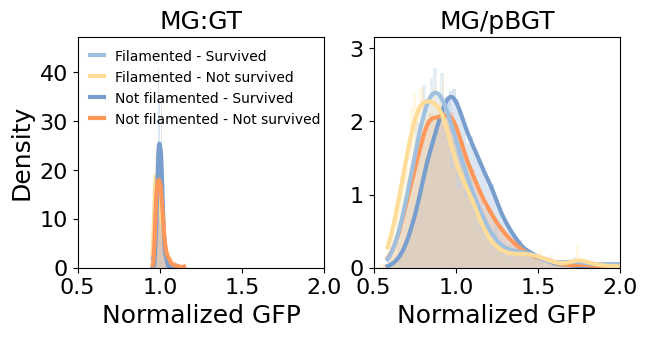

In [18]:
from scipy.stats import gaussian_kde

def plot_gfp_distributions(lineages_df):
  # Define the colors for each cell status
  colors = {
          "Not filamented - Survived": dark_blue,
          "Not filamented - Not survived": dark_orange,
          "Filamented - Survived": light_blue,
          "Filamented - Not survived": light_orange
        }


  # Create a new figure with subplots for each cell status
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

  # Loop over each experiment_id
  for i, experiment_id in enumerate(lineages_df["experiment_id"].unique()):
      # Get the subset of the dataframe corresponding to the current experiment_id
      exp_df = lineages_df.loc[(lineages_df["experiment_id"] == experiment_id) & (lineages_df["time"] < t_antibiotic_start)]

      # Get the unique cell statuses for the current experiment_id
      cell_statuses = exp_df["cell_status"].unique()

      nbins=20
      max_gfp=exp_df['gfp_first'].max()
      min_gfp=exp_df['gfp_first'].min()
      bins = np.linspace(min_gfp, max_gfp, nbins)

      # Loop over each cell status and plot the corresponding histogram
      list_gfp=[]
      for cell_status in (cell_statuses):
          # Get the subset of the dataframe corresponding to the current cell status
          cell_df = exp_df.loc[exp_df["cell_status"] == cell_status]

          # Plot the histogram of 'gfp' values for the current cell status
          if experiment_id=='Plasmid':
            axs[i].hist(cell_df["gfp"], bins=100,label=cell_status, color=colors[cell_status], alpha=0.25, density=True, linewidth=0)
          else:
            axs[i].hist(cell_df["gfp"], bins=100,color=colors[cell_status], alpha=0.25, density=True, linewidth=0)
          axs[i].set_xlabel("Normalized GFP", fontsize=18)
          axs[i].tick_params(axis='both', labelsize=16)


          list_gfp.append(cell_df["gfp"])


          kde = gaussian_kde(cell_df["gfp"])
          x = np.linspace(bins[0], bins[-1], 1000)
          y = kde(x)

          # Plot the KDE
          axs[i].plot(x, y, color=colors[cell_status], linewidth=3, label=cell_status)

          list_gfp.append(cell_df["gfp"])

          # Plot a vertical line at the mode of the distribution
          #axs[i].axvline(x=mode, color=colors[cell_status], linestyle=":")
      if experiment_id == 'Plasmid':
        lbl_experiment='MG/pBGT'
      else:
        lbl_experiment='MG:GT'

      axs[i].set_title(lbl_experiment, fontsize=18)
      axs[i].set_xlim([0.5,2])
      ylim = axs[i].get_ylim()
      axs[i].set_ylim([0, ylim[1]*1.1])

      axs[0].set_ylabel("Density", fontsize=18)
      axs[0].legend(fontsize=10,frameon=False,handlelength=1,loc='upper left')

      if experiment_id=='Plasmid':
        t_statistic, p_value = ttest_ind(list_gfp[0], list_gfp[2])
        print("\tT-statistic:", t_statistic)
        print("\tP-value:", p_value)
        if(p_value<0.05):
          print("\t\tStatistically significant!")


  #plt.show()

  out_fig_name=fig_path+'Fig-4C.pdf'
  print("Saving fig as: \n",out_fig_name)
  plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)


plot_gfp_distributions(lineages_processed_df)


# Figure 4D

The following code defines a function **plot_duplication_rates** that plots a histogram of the number of divisions of each lineage prior to drug exposure. The function takes in two arguments, lineages_df which is a pandas dataframe containing information on the lineage of the cells, and t_antibiotic_start which is a scalar indicating the time (in minutes) when the antibiotic is added.

The function groups the data by experiment ID and ID, and counts the number of divisions for each lineage prior to drug exposure. It then creates a separate histogram for each experiment ID and plots them using different colors. The function returns a list containing the division counts for each experiment ID.

Survived
Not survived
Survived
Not survived
[0. 2. 4. 6. 8.]
Mean #duplications (MG:GT): 1.386759581881533
Mean #duplications (MG/pBGT): 0.5620753551575046
Mean time elapse (in minutes) between two consecutive cell division events  (MG:GT): 38.74197689345315
Mean time elapsed (in minutes) between two consecutive cell division events  (MG/pBGT): 87.13721061547149
Saving fig as: 
 /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/figures/Fig-4D.pdf
Chromosome vs Plasmid
	T-statistic: 33.08000506039464
	P-value: 7.709131250659691e-223
		Statistically significant!
Survived  vs Not survived
	T-statistic: 7.150163283250841
	P-value: 9.56093185955178e-13
		Statistically significant!


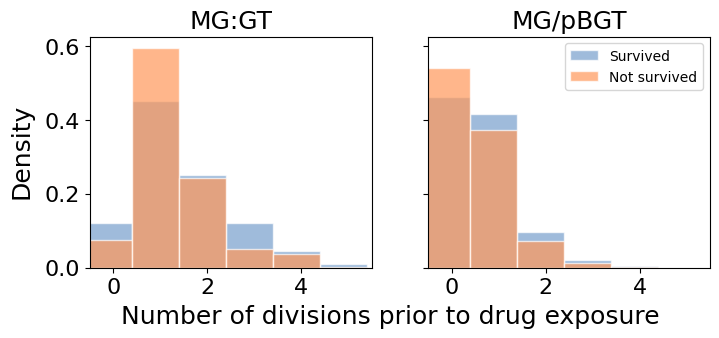

In [19]:
def plot_duplication_rates(lineages_df, t_antibiotic_start):

    # Define the x-axis range and tick positions
    #xlim = (0, lineages_df["length"].max() + 1)
    xlim = (0-.1, 10)
    xticks = np.arange(0, xlim[1], 1)

    # Group the data by experiment_id and id, and count the number of divisions
    counts_df = lineages_df.groupby(["experiment_id", "id"])["division"].sum().reset_index()

    exp_counts=[]
    colors2 = [ dark_blue,  dark_orange]

    # Create a new figure
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3), sharey=True, sharex=True)

    # Loop over each experiment_id
    for ie, experiment_id in enumerate(lineages_df["experiment_id"].unique()):
        # Get the subset of the dataframe corresponding to the current experiment_id
        #exp_df = lineages_df.loc[lineages_df["experiment_id"] == experiment_id]

        exp_df = lineages_df.loc[(lineages_df["experiment_id"] == experiment_id) & (lineages_df["time"] < t_antibiotic_start)]

        for isurv,survive_id in enumerate(exp_df.survived.unique()):
            print(survive_id)
            exp_surv_df=exp_df[exp_df["survived"]==survive_id]
            # Group the data by id, and count the number of divisions
            counts_df = exp_surv_df.groupby("id")["division"].sum().reset_index()
            #display(counts_df.division.describe())
            # Create a histogram of the division counts
            this_bins=np.arange(xlim[0], xlim[1] + 1, 1)
            #print(this_bins)
            n,b,p=axes[ie].hist(counts_df["division"], bins=this_bins, alpha=0.7, edgecolor='w', color=colors2[isurv], density=True,label=survive_id)

            exp_counts.append(list(counts_df["division"]))

            axes[ie].set_xlim([0,10])
            #axes[i].set_xlabel({}, fontsize=18)
            #axes[i].set_ylabel("Count", fontsize=18)

            if experiment_id == 'Plasmid':
                lbl_experiment='MG/pBGT'
            else:
                lbl_experiment='MG:GT'

            axes[ie].set_title("{}".format(lbl_experiment), fontsize=18)

            axes[ie].tick_params(axis='both', labelsize=16)

    # Set the x-axis label for the entire figure

    fig.text(0.5, -0.075, 'Number of divisions prior to drug exposure', ha='center', fontsize=18)
    plt.xlim([0,7])
    xst=axes[0].get_xticks()
    print(xst)
    xst=[int(x) for x in xst]
    xst2=np.array(xst)
    xst2=xst2+.5
    xst=axes[0].set_xticks(xst2,labels=xst)
    axes[0].set_xlim([0,6])
    axes[1].set_xlim([0,6])
    axes[1].legend()
    # Add a common y-axis label
    fig.text(0.04, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=18)

    return exp_counts


exp_counts=plot_duplication_rates(lineages_processed_df, t_antibiotic_start)
print("Mean #duplications (MG:GT):",np.mean(exp_counts[1]))
print("Mean #duplications (MG/pBGT):",np.mean(exp_counts[3]))

print("Mean time elapse (in minutes) between two consecutive cell division events  (MG:GT):",60/np.mean(exp_counts[0]))
print("Mean time elapsed (in minutes) between two consecutive cell division events  (MG/pBGT):",60/np.mean(exp_counts[2]))

out_fig_name=fig_path+'Fig-4D.pdf'
print("Saving fig as: \n",out_fig_name)
plt.savefig(out_fig_name,bbox_inches = 'tight',pad_inches = 0.1)


print('Chromosome vs Plasmid')
t_statistic, p_value = ttest_ind(exp_counts[0]+ exp_counts[1],exp_counts[2]+ exp_counts[3])
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")

print('Survived  vs Not survived')
t_statistic, p_value = ttest_ind(exp_counts[0]+ exp_counts[2],exp_counts[1]+ exp_counts[3])
print("\tT-statistic:", t_statistic)
print("\tP-value:", p_value)
if(p_value<0.05):
    print("\t\tStatistically significant!")




# Figure 4EF

The function **get_surv_rates_pbgt()** computes the survival rates of cells expressing plasmids over time, based on their GFP expression levels. It takes a dataframe of cell status and time data as input.

The function first filters the dataframe to only include cells from the plasmid experiment, then normalizes the GFP expression levels to between 0 and 1. It creates a set of GFP bins and calculates the survival rates of cells falling into each bin at each time point.

The function then normalizes the survival rates by the survival rates at the first time point, and crops the survival rates to only include GFP bins within a specified range. The means of the cropped sections are calculated and inserted as the first and last rows of the survival rate array. The function returns the survival rate array and the cropped GFP bins.


In [20]:

def get_surv_rates_pbgt(status_time_df):

  experiment_id='Plasmid'
  gfp_low=0.26
  gfp_high=0.75
  nbins=20

      # Filter for experiment_id == 'Plasmid'
  df = status_time_df[status_time_df['experiment_id'] == experiment_id].copy()

  normalize_time=df.antibiotic_start_time.unique().item()

  # Define the time steps to plot
  times = np.sort(df['time'].unique())
  max_gfp=df['gfp_first'].max()
  min_gfp=df['gfp_first'].min()

  df['gfp_first'] = df['gfp_first']/max_gfp
  max_gfp=df['gfp_first'].max()
  min_gfp=df['gfp_first'].min()
  gfp_bins = np.linspace(0, 1, nbins)


  # Calculate the survival rates for each combination of time and GFP bin
  survival_counts = []
  for t in times:

      t_df = df[df['time'] == t]
      t_survived_counts = t_df[t_df['survived'] == 'Survived'].groupby(
          pd.cut(t_df['gfp_first'], gfp_bins)).size()

      if t==normalize_time:
          t_counts=t_survived_counts.values

      survival_counts.append(t_survived_counts.values)
  survival_counts = np.array(survival_counts).T

  # Normalize the survival rates by the survival rates at the specified time point
  survival_rates=[]
  for ti,t in enumerate(times):
      this_surv_rate=np.nan_to_num(survival_counts[:,ti] / t_counts)
      survival_rates.append(this_surv_rate)
  surv_rate_df=100*pd.DataFrame(survival_rates).T

  #Only consider relevant bins
  cropped_bins1=gfp_bins[gfp_bins<gfp_low]
  cropped_bins2=gfp_bins[gfp_bins>gfp_high]
  cropped_bins=(np.concatenate((cropped_bins1, cropped_bins2)))
  matching_indices = np.where(np.in1d(gfp_bins,cropped_bins))[0]
  N=len(cropped_bins1)
  M=len(cropped_bins2)

  # Crop the array
  surv_arr = surv_rate_df[N:-M]

  # Calculate the means of the cropped sections
  first_mean = np.mean(surv_rate_df[:N], axis=0)
  last_mean = np.mean(surv_rate_df[-M:], axis=0)

  # Insert the means as the first and last rows of the cropped array
  surv_arr = np.vstack([first_mean, surv_arr, last_mean])

  gfp_bins_cropped=gfp_bins[np.setdiff1d(np.arange(0, len(gfp_bins)), matching_indices)]

  return surv_arr, gfp_bins_cropped



The function **plot_survival_heatmap_gfp()** takes in a survival rate array and a GFP bin array and generates a heatmap plot where each row represents a different GFP intensity bin and each column represents a different time point. The color of each cell in the heatmap corresponds to the survival rate for the corresponding GFP bin and time point. The y-axis of the plot is labeled with the normalized fluorescent intensity of the cells.

In [25]:
def plot_survival_heatmap_gfp(surv_rates, gfp_bins, t_antibiotic, vmin=0, vmax=100):
    # Calculate the number of GFP bins
    nbins = len(gfp_bins)

    # Define the color stops and corresponding colors for the gradient
    color_stops = [0., 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    colors_list = ['#E06800', dark_orange, light_orange, 'white', light_blue, dark_blue, '#3B638C']

    # Create the colormap
    colormap = colors.LinearSegmentedColormap.from_list("", list(zip(color_stops, colors_list)))

    # Create the heatmap plot
    fig, ax = plt.subplots(figsize=(8, 7.2))
    fig.set_facecolor('white')

    heatmap = sns.heatmap(surv_rates, cmap=colormap, ax=ax, cbar_kws={'label': 'Survival Rate', 'orientation': 'horizontal', 'location':'top'}, vmin=vmin, vmax=vmax)
    heatmap.invert_yaxis()
    ax.set_xlabel('Time (minutes)', fontsize=18)

    # Set x-axis limits and tick labels
    ax.set_xlim((t_antibiotic[0]/frame2min, 24))
    ax.set_xticks(np.linspace(t_antibiotic[0]/frame2min,25,4))
    ax.set_xticklabels([f'{int(tick)}' for tick in np.linspace(0,180,4)], fontsize=16)



    # Set y-axis ticks and labels to the GFP bins
    yticks = np.arange(nbins) + 1.5
    yticklabels = [f'<{gfp_bins[0]:.2f}']
    yticklabels += [f'{g:.2f}' for g in gfp_bins[1:-1]]
    yticklabels += [f'>{gfp_bins[-1]:.2f}']
    dy=(yticks[2]-yticks[1])
    ax.set_yticks(yticks-dy)
    ax.set_ylim([0, yticks[-1]-dy/2])
    ax.set_yticklabels(yticklabels, rotation=0, fontsize=16)
    ax.set_ylabel('Normalized fluorescence intensity', fontsize=18)

    # Add color bar for heatmap
    cbar = heatmap.collections[0].colorbar
    cax = cbar.ax  # get the ax of the colorbar
    pos = cax.get_position()  # get the original position
    cax.set_position([pos.x0+pos.width * 0.4, pos.y0, pos.width * 0.6, pos.height])  # set a new position
    cax.set_frame_on(True)
    cbar.ax.set_xlim([40,100])



    cbar.ax.tick_params(labelsize=16)  # set font size of tick labels
    cbar.ax.set_xlabel('Cells alive (%)', fontsize=18)  # set font size of the label
    cbar.ax.tick_params(labelsize=16, length=0) # Remove tick marks
    cbar.ax.xaxis.set_ticks_position('top') # Set ticks to be on the top axis
    cbar.ax.xaxis.set_label_position('top') # Set label to be on the top axis
    for spine in cax.spines.values():  # show the colorbar frame again
     spine.set(visible=True, lw=.8, edgecolor='black')

    print(yticks[-1]+2,ax.get_ylim(),)

    #plt.arrow(10,10,5,5)
    ax.annotate('', xy=(0, 1.05), xycoords='axes fraction',
            xytext=(0.425, 1.05), textcoords='axes fraction',
            va ='center', ha='center',
            arrowprops=dict(facecolor='black', shrinkA=5, shrinkB=5,arrowstyle='<|-|>',lw=2))
    plt.annotate('AMP', xy=(0,1.1), xytext=(0.175,1.075),xycoords='axes fraction',
                 weight='bold',fontsize=16,
             textcoords='axes fraction')
    # ax.annotate('', xy=(0, 1.0), xycoords='axes fraction',
    #             xytext=(0.,1.1), textcoords='axes fraction',
    #             arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')
    x0=t_antibiotic[0]/frame2min
    ax.annotate('', xy=(x0, yticks[-1]-dy/2), xycoords='data',
                xytext=(x0,yticks[-1]+dy/2), textcoords='data',zorder=2,
                arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')
    x0=t_antibiotic[1]/frame2min
    ax.annotate('', xy=(x0, yticks[-1]-dy/2), xycoords='data',
                xytext=(x0,yticks[-1]+dy/2), textcoords='data',zorder=2,
                arrowprops={'arrowstyle': '-', 'ls': 'dashed'}, va='center')

    # Show the plot
    #plt.tight_layout()
    #plt.show()
    return fig



The **plot_survival_histogram_gfp()** function takes survival rates and GFP bins as inputs and creates a histogram plot showing the final survival rates for each GFP bin. The plot is colored according to the final survival rates, with a colormap specified by cmap. The function also has an optional argument t_surv, which specifies the time point at which to calculate the final survival rates. If t_surv is not specified, the final survival rates are calculated at the last time point.

In [23]:
def plot_survival_histogram_gfp(surv_rates, gfp_bins, t_surv=-1,  vmin=0, vmax=100):
    nbins = len(gfp_bins)

    # Define the color stops and corresponding colors for the gradient
    color_stops = [0., 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    colors_list = ['#E06800', dark_orange, light_orange, 'white', light_blue, dark_blue, '#3B638C']

    # Create the colormap
    colormap = colors.LinearSegmentedColormap.from_list("", list(zip(color_stops, colors_list)))

    # Calculate the final survival rates for each GFP bin
    final_rates = surv_rates[:, t_surv]
    dy = gfp_bins[2] - gfp_bins[1]

    # Create the histogram plot
    fig, ax = plt.subplots(figsize=(4, 5.9))
    fig.set_facecolor('white')

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    #cmap = plt.cm.get_cmap(cmap)
    cols = colormap(norm(final_rates[:-1]), alpha=1.0)
    rects = ax.barh(gfp_bins, final_rates[:-1], align='center', edgecolor='grey', height=dy, color=cols)

    # Set y-axis ticks and labels to the GFP bins
    ax.set_yticks(gfp_bins)
    ax.set_ylim([gfp_bins[0]-dy/2, gfp_bins[-1]+dy/2])
    ax.set_yticklabels([])
    #ax.set_yticklabels([f'<{gfp_bins[0]:.2f}'] + [f'{g:.2f}' for g in gfp_bins[1:-1]] + [f'>{gfp_bins[-1]:.2f}'], fontsize=16)
    #ax.set_ylabel('GFP', fontsize=18)

    # Set x-axis limits and tick labels
    ax.set_xlabel('Cells alive (%)', fontsize=18)
    ax.set_xlim([vmin, vmax])
    ax.tick_params(axis='both', labelsize=16)

    #plt.show()
    plt.tight_layout()
    #plt.show()
    return fig

### MG:pBGT

The following code performs survival analysis based on two different definitions of survival.

The first criterion for cell death is that the cell is not observed until the end of the experiment and the ds_red is above a certain threshold, as indicated by the cell_status column containing the string 'Not survived'. This criterion captures all cells that died by cell lysis or disappeared during the experiment.

The second criterion captures cells that were exposed to an antibiotic and did not undergo cell division after the exposure. This criterion captures cells that were unable to overcome the antibiotic-induced stress and did not proliferate further.

<ipython-input-20-8b6e384ac74a>:41: RuntimeWarning: invalid value encountered in divide
  this_surv_rate=np.nan_to_num(survival_counts[:,ti] / t_counts)


12.5 (0.0, 10.0)


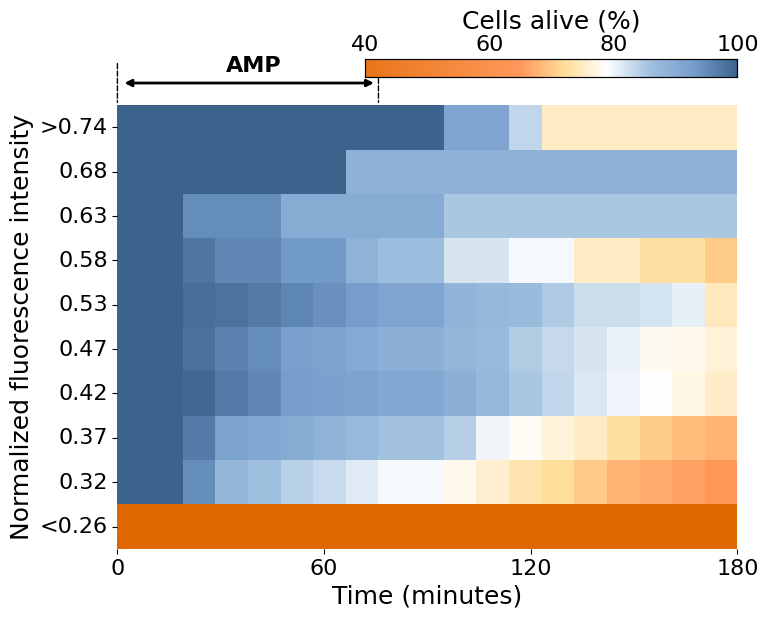

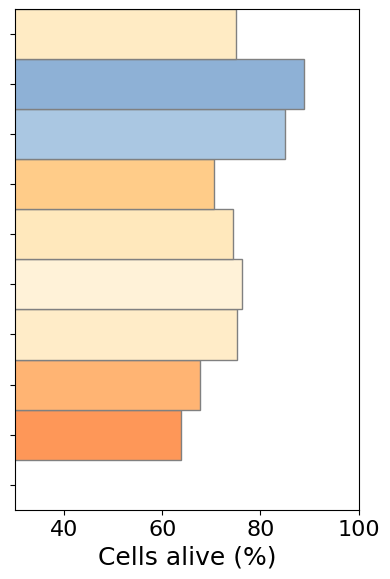

In [26]:
# Set the time of antibiotic administration in minutes
t_antibiotic=[60, 140]

# Calculate survival rates and GFP bins using the "get_surv_rates_pbgt" function with input data "status_time_df"
surv_rates, gfp_bins = get_surv_rates_pbgt(status_time_df)

# Create a heatmap plot of the survival rates for each combination of time and GFP bin using the "plot_survival_heatmap_gfp" function
fig=plot_survival_heatmap_gfp(surv_rates, gfp_bins, t_antibiotic, vmin=30, vmax=100)
figname=fig_path+"Fig-4E.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()


# Create a histogram plot of the final survival rates for each GFP bin using the "plot_survival_histogram_gfp" function
fig=plot_survival_histogram_gfp(surv_rates, gfp_bins, vmin=30, vmax=100)
figname=fig_path+"Fig-4F.pdf"
plt.savefig(figname,bbox_inches = 'tight',pad_inches = 0.1)
plt.show()